# 지상 일기도 제작


## 관측소 일기 기호 기입

아이오와 주립대 아카이브 자료 사용  
https://mesonet.agron.iastate.edu/request/download.phtml?network=KR__ASOS  
중국, 일본, 한국, 필리핀 자료 사용

In [1]:
from datetime import datetime
import metpy.calc as mpcalc
from scipy.ndimage import gaussian_filter
import xarray as xr

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import wind_components, altimeter_to_sea_level_pressure
from metpy.cbook import get_test_data
from metpy.plots import (add_metpy_logo, simple_layout, StationPlot,
                         StationPlotLayout, wx_code_map)
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units

In [2]:
#asos 지상관측자료
path1 = r'/Users/hojjunekim/Desktop/Final_project/asos_19090900_KR.txt'
path2 = r'/Users/hojjunekim/Desktop/Final_project/asos_19090900_JP.txt'
path3 = r'/Users/hojjunekim/Desktop/Final_project/asos_19090900_CN.txt'
path4 = r'/Users/hojjunekim/Desktop/Final_project/asos_19090900_PP.txt'

cols = (0,1,2,3,5,6,8,9,11,12,15,16,17,23)
var = ['stid','time','lon','lat','air_temperature','dew_point_temperature',\
        'wind_dir','wind_speed','altimeter','sea_level_pressure',\
        'sky1','sky2','sky3','weather']

kr = pd.read_csv(path1, usecols=cols, names=var, na_values='M', header=0)
stid = ['QEP', 'RKPC', 'RKPK','RKSO', 'QEN'] # 광주, 부산, 제주, 대관령
kr.set_index('stid', inplace=True)
kr = kr.loc[stid]
kr = kr.reset_index()

jp = pd.read_csv(path2, usecols=cols, names=var, na_values='M', header=0)
stid = ['ROIG', 'ROAH', 'RJFG', 'RJAW',  # 이시가키, 오키나와, 타네가시마, 이와지마
         'RJFK', 'RJFF', 'RJOS', 'RJOW', 'RJOO',  #가고시마, 후쿠오카, 토쿠시마, 이와미, 오사카
         'RJTF', 'RJSF', 'RJNT', 'RJSS',  # 도쿄, 후쿠시마, 토야마, 센다이
         'RJSK', 'RJSA', 'RJCC']                 # 아키타, 아오모리, 삿포로
jp.set_index('stid', inplace=True)
jp = jp.loc[stid]
jp = jp.reset_index()

cn = pd.read_csv(path3, usecols=cols, names=var, na_values='M', header=0)

pp = pd.read_csv(path4, usecols=cols, names=var, na_values='M', header=0)
stid = ['RPVM', 'RPLI', 'RPLL','RPLC', 'RPVD']
pp.set_index('stid', inplace=True)
pp = pp.loc[stid]
pp = pp.reset_index()

df = pd.concat([kr,jp,cn,pp])
df.set_index('time', inplace=True)
df = df.loc['2019-09-09 00:00']
df = df.reset_index()

In [3]:
# 운량 정보가 층별로 CLR, FEW, SCT, BKN, OVC로 되어 있으므로 이를 우리가 아는 10분운량으로 바꿔줘야 함
cloud = df.loc[:,['sky1','sky2','sky3']]
mapping = {'CLR':0, 'FEW':1, 'SCT':3, 'BKN':6, 'OVC':8, 'NCD':np.nan, 'NSC':np.nan}
cloud_convert = cloud.applymap(lambda s: mapping.get(s) if s in mapping else s)
cloud_fraction = cloud_convert.max(axis=1,skipna=True)
cloud_fraction.name = 'cloud_fraction'
df = df.join(cloud_fraction, )
df = df.dropna(how='any', subset=['wind_speed', 'wind_dir', 'altimeter'])

In [4]:
data = {}
data['longitude'] = df['lon'].values
data['latitude'] = df['lat'].values
data['air_temperature'] = df['air_temperature'].values * units.degF
data['dew_point_temperature'] = df['dew_point_temperature'].values * units.degF
data['air_temperature'] = data['air_temperature'].to(units.degC)
data['dew_point_temperature'] = data['dew_point_temperature'].to(units.degC)
data['altimeter'] = df['altimeter'].values * 1013.25 / 29.92 * units('mbar')



In [5]:
# 해면기압 자료를 수은기둥 높이 해면경정으로 이용

# 관측소 고도 자료 
path4 = r'/Users/hojjunekim/Desktop/Final_project/iem_kr_station.txt'
path5 = r'/Users/hojjunekim/Desktop/Final_project/iem_jp_station.txt'
path6 = r'/Users/hojjunekim/Desktop/Final_project/iem_cn_station.txt'
path7 = r'/Users/hojjunekim/Desktop/Final_project/iem_pp_station.txt'

st1 = pd.read_csv(path4)
st2 = pd.read_csv(path5)
st3 = pd.read_csv(path6)
st4 = pd.read_csv(path7)
df3 = pd.concat([st1, st2, st3, st4])
df3 = df3.dropna(how='any', subset=['elev'])
df3.set_index('stid', inplace=True)
stid = df['stid']
data['elevation'] = df3['elev'][stid].values * units.m

# 해면경정
data['sea_level_pressure'] = altimeter_to_sea_level_pressure(data['altimeter'],data['elevation'], data['air_temperature'])

In [6]:
u, v = wind_components(df['wind_speed'].values * units('knots'),
                       df['wind_dir'].values * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
data['cloud_coverage'] = df['cloud_fraction'].fillna(0).values.astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
wx_text = df['weather'].fillna('')
data['present_weather'] = [wx_code_map[s.split()[0] if ' ' in s else s] for s in wx_text]

In [7]:
proj = ccrs.LambertConformal(central_longitude=120, central_latitude=35,
                             standard_parallels=[35])

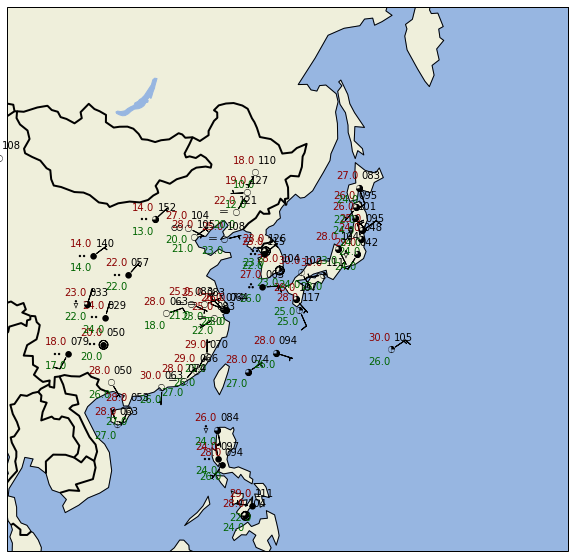

In [8]:
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=5)
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('NE', 'sea_level_pressure', fmt=lambda v: format(10 * v, '.0f')[-3:], units='mbar', color='black', fontsize=10)
custom_layout.add_symbol('W','present_weather', current_weather)
custom_layout.add_symbol('C','cloud_coverage', sky_cover, fontsize=7)

# Create the figure and an axes set to the projection
plt.rcParams['savefig.dpi'] = 255
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
#ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.set_extent((100, 155, 5, 60))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)

plt.show()

## 등압선 기입

ERA5 재분석장 자료 사용  
grid 0.25, 0.25로 설정하여 25km 격자 자료로 사용
gaussian filter 사용 안함(주석 처리 또는 sigma = 0)

In [9]:
dt = datetime(2019, 9, 1, 12)

path = '/Users/hojjunekim/Desktop/Final_project/'
fname1 = 'era5_sfc_' + dt.strftime("%Y%m%d%H") + '.nc'

In [10]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [0.25, 0.25],
        
    },
    path + fname1)

2020-12-03 23:41:25,934 INFO Welcome to the CDS
2020-12-03 23:41:25,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-12-03 23:41:27,249 INFO Request is queued
2020-12-03 23:41:28,567 INFO Request is completed
2020-12-03 23:41:28,568 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1607006487.2649217-1973-15-eda8bc49-4e14-463e-b1f9-f114bab49452.nc to /Users/hojjunekim/Desktop/Final_project/era5_sfc_2019090112.nc (4M)
2020-12-03 23:41:35,553 INFO Download rate 582.2K/s 


Result(content_length=4162968,content_type=application/x-netcdf,location=http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1607006487.2649217-1973-15-eda8bc49-4e14-463e-b1f9-f114bab49452.nc)

In [50]:
ds = xr.open_dataset(path+fname1)
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2019-09-01T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-29 19:27:46 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [51]:
# Select and grab data, at/lon values 
pres= ds['msl'].sel(time=dt,latitude=slice(90,0), longitude=slice(60,201))[...]
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
#pres = gaussian_filter(pres.data, sigma=1) / 100. * units('hPa')
pres = pres.data/100*units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

In [ ]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

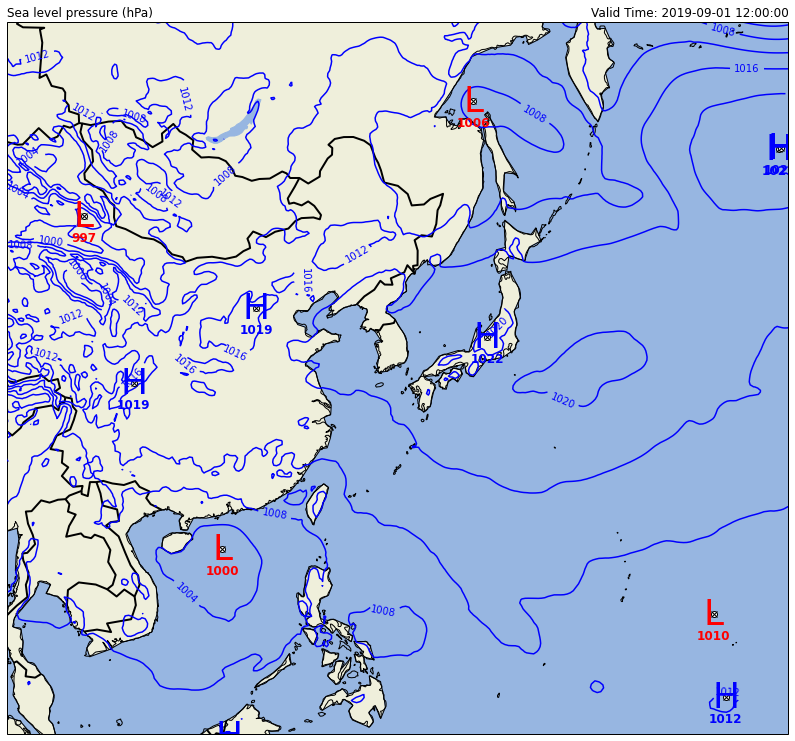

In [52]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
#ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.set_extent([100, 155, 5, 60], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 80,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 80,
                   symbol='L', color='red', transform=ccrs.PlateCarree())


# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

## 모두 기입하여 지상 일기도 제작

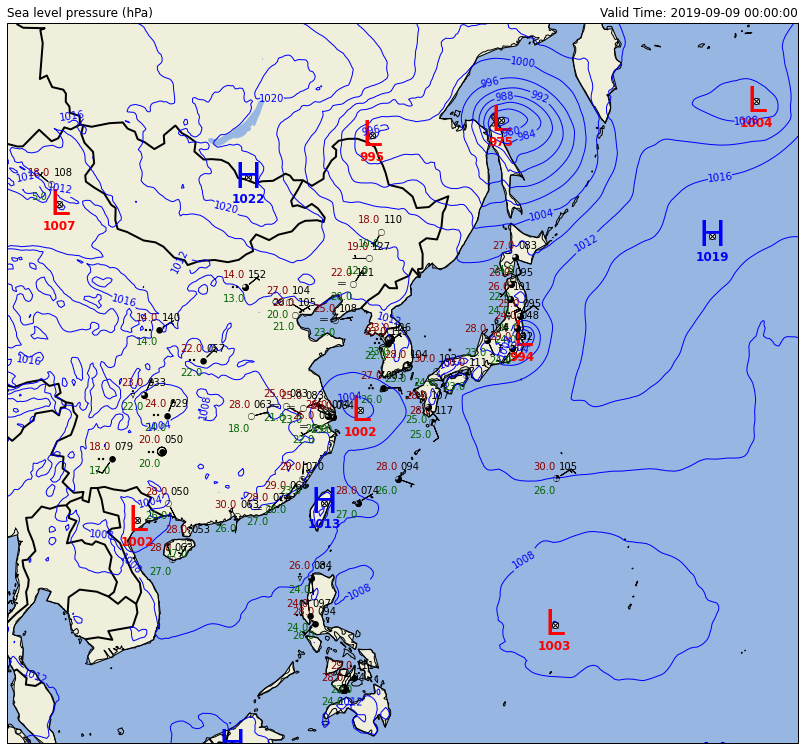

In [326]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
#plt.rcParams['savefig.dpi'] = 255
fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1, 1, 1, projection=proj)
#fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([100, 155, 5, 60], ccrs.PlateCarree())

###################

custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=5)
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('NE', 'sea_level_pressure', fmt=lambda v: format(10 * v, '.0f')[-3:], units='mbar', color='black', fontsize=10)
custom_layout.add_symbol('W','present_weather', current_weather)
custom_layout.add_symbol('C','cloud_coverage', sky_cover, fontsize=7)

# Create the figure and an axes set to the projection
#plt.rcParams['savefig.dpi'] = 255
#fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
#ax.set_extent((90, 150, 20, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)

###################

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', linewidths=1.0, transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols

plot_maxmin_points(lons, lats, pres.m, 'max', 80,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 80,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')


# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)